# Test for systematics that become visible by comparison of multiple light curves in a campaign

## Run the LCs through appaloosa

In [2]:
for oid in oid_list:
    RunLC_test(oid)

NameError: name 'oid_list' is not defined

## Load everything

In [11]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from appaloosa import RunLC
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

def RunLC_test(oid):
    loc = 'stars_shortlist/M67'
    tpf_loc = 'stars_shortlist/M67/ktwo{}-c05_lpd-targ.fits.gz'.format(oid)
    lc_loc = 'stars_shortlist/M67/hlsp_everest_k2_llc_{}-c05_kepler_v2.0_lc.fits'.format(oid)
    os.chdir('/home/ekaterina/Documents/appaloosa')
    RunLC(lc_loc, dbmode='everest', display=False, debug=False, dofake=False, writeout=True)
    return

def display_overlay(oid_list,location, start, stop):

    os.chdir(location)
    all_flux={}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, oid in enumerate(oid_list):
        flux = pd.read_csv(str(oid)+'_flux.csv',
                          usecols = ['flux_gap','time'])
        s = start
        t = stop
        mean = flux.flux_gap.median()
        plt.plot(list(flux.time)[s:t],list(flux.flux_gap/mean)[s:t],label='EPIC {}'.format(oid))
    plt.show()
    return
    
def edges_to_bool(start_stop):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(row.istart,row.istop)))
    isflare = np.zeros(start_stop.istop.iloc[-1]+1)
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare

def create_inflated_binoms(oid_list,p,maxlen,display=False):

    inflated_binoms={}
    for i in [1,3,5]:
        binom = 0
        for oid in oid_list:
            not_inflated = np.random.binomial(1,p[oid]/i,maxlen//i)
            inflated = [item for sublist in [[j]*i for j in not_inflated] for item in sublist]
            binom = np.add(inflated,binom)
        inflated_binoms[i]=binom
    if display == True:
        plt.plot(inflated_binoms[3])
    
    return inflated_binoms

def remove_systematics(seq,maxlen):
    
    #create cleaned data frame:
    systematics = list(seq[5<seq.sum(axis=1)].index)
    remove = sorted(list(set([item for sublist in [[i-1,i,i+1] for i in systematics] for item in sublist])))
    seq_drop = seq.drop(labels=remove)
    
    #overlap dirty, overlap clean:
    od = [seq[seq.sum(axis=1)>=i].shape[0] for i in range(21)]
    oc = [seq_drop[seq_drop.sum(axis=1)>=i].shape[0] for i in range(21)]

    #Calculate the binomial probability for cleaned version
    p = seq.sum()/maxlen
    return od, oc, p, remove

def display_comparison(inflated_binoms, overlap_dirty,overlap_clean):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i,binom in inflated_binoms.items():
        overlap_binom, edges = np.histogram(binom, bins=21, range=(0,21))
        #print(overlap_binom)
        overlap_binom = np.cumsum(overlap_binom[::-1])[::-1]
        #print(overlap_binom,'\n',overlap)
        ax.plot(overlap_binom,label='{}-times inflated binomial distribution'.format(i))
    ax.plot(overlap_dirty,label='Real distribution with systematic errors')
    ax.plot(overlap_clean,label='Real distribution - systematics removed')
    #ax.plot(np.array(overlap)-overlap_binom,label='real-random')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_yscale('log')
    fig.show()
    return

def generate_sequence(oid_list,location):

    os.chdir(location)

    all_isflare = {}
    for oid in oid_list:

        start_stop = pd.read_csv(str(oid)+'_flares.csv',
                                usecols = ['istart','istop'])
        all_isflare[oid] = edges_to_bool(start_stop)

    maxlen = max([len(val) for key,val in all_isflare.items()])

    for key, val in all_isflare.items():
        all_isflare[key] = np.concatenate((val,np.zeros(maxlen-len(val))))
        #print(len(val))
    seq = pd.DataFrame(all_isflare)
    return maxlen, seq
    

In [12]:
os.chdir('/home/ekaterina/Documents/appaloosa')
oid_list = pd.read_csv('stars_shortlist/M67/M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()


## Use the results or jump in here if LCs have been processed earlier

### Import the flare candidates first and reframe as boolean arrays of flare/not flare in time domain

In [13]:
location = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results/test_11'
maxlen, seq = generate_sequence(oid_list, location)
seq.head()

,211395699,211396422,211403974,211405388,211406540,211407971,211409099,211410963,211411112,211411477,...,211411894,211412571,211413212,211416648,211417817,211418176,211418561,211427268,211427574,228682441
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove systematics as time intervals where flares overlap for more than 30% of all LCs

In [14]:
overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen)

### Introduce a binomial distribution for comparison, also some where flare time point occur in clusters of 3 or 5 time points

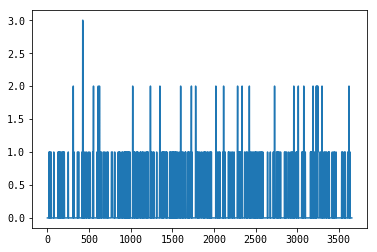

In [15]:
inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=True)

### Now compare the cleaned version with the uncleaned one and also the (inflated) binomials:

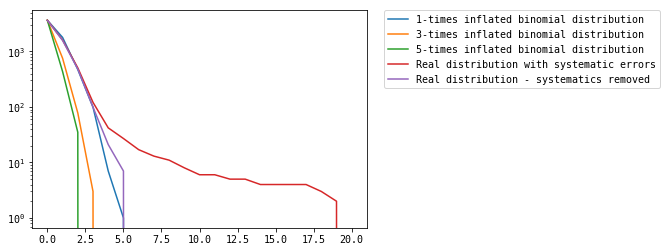

In [16]:
display_comparison(inflated_binoms, overlap_dirty, overlap_clean)

## Appendix: Example of a systematic in a light curve

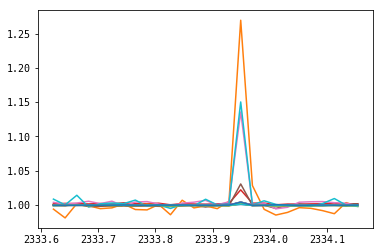

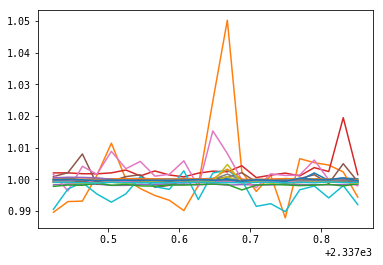

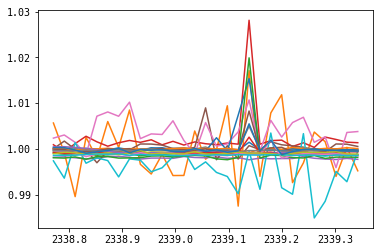

[(1322, 1349), (1508, 1530), (1574, 1603)]

In [28]:
#FCOR
#display_overlay(oid_list,location, 1330, 1360)
#FLUX
#display_overlay(oid_list, location, 1310, 1330)
#pop remove list
def systematic_set(remove):
    
    s=[]
    j = 0
    for i, item in enumerate(remove[:-1]):
            if item+1 != remove[i+1]:
                s.append(remove[j:i+1])
                j = i+1 
    return s
                
sset = systematic_set(remove)            
display_list = [(l[0]-10,l[-1]+10) for l in sset]
for (on, off) in display_list:
    display_overlay(oid_list, location, on, off)
display_list

## Pixel Test 1:
Compare two LCs that both shows CR flags simulatenously while all the others in the sample do not. They have same RA, but 4' apart in DEC.

In [19]:
import k2flix
tpf3 = k2flix.TargetPixelFile('ktwo{}-c05_lpd-targ.fits.gz'.format('211411894'))
tpf4 = k2flix.TargetPixelFile('ktwo{}-c05_lpd-targ.fits.gz'.format('211407971'))
tpf3.save_movie(output_fn='211411894_test.gif', start=1360, stop=1370, step=1,
               binning=1, fps=1, dpi=None, stretch='log',
               min_cut=None, max_cut=None, min_percent=60, max_percent=100,
               cmap='gray', time_format='frameno', show_flags=True, data_col='FLUX',
               ignore_bad_frames=True,)
tpf4.save_movie(output_fn='211407971_test.gif', start=1360, stop=1370, step=1,
               binning=1, fps=1, dpi=None, stretch='log',
               min_cut=None, max_cut=None, min_percent=60, max_percent=100,
               cmap='gray', time_format='frameno', show_flags=True, data_col='FLUX',
               ignore_bad_frames=True,)


FileNotFoundError: [Errno 2] No such file or directory: 'ktwo211411894-c05_lpd-targ.fits.gz'

## Pixel Test 2:

Check all the quality flags:

In [57]:
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/M67')
import k2flix
crs = dict()
for oid in oid_list:
    #print('\n{}:\n'.format(oid))
    tpf2 = k2flix.TargetPixelFile('ktwo{}-c05_lpd-targ.fits.gz'.format(oid))
    j = 0
    for i in range(3600):
        a = tpf2.hdulist[1].data['QUALITY'][i]
        #print(a)
        #a = tpf2.quality_flags(i)
        if 16384*64 == a:
            j+=1
            #print('{}: {}'.format(i,a))
    crs[oid] = j/3600*100



## WRAP-UP: Do all steps in one!

In [44]:
def systematics_wrap(location, oid_list, display=False):
    maxlen, seq = generate_sequence(oid_list, location)
    overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen)
    sys_set = pd.Series([i for item in systematic_set(remove) for i in item])
    inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=display)
    sys_set.to_csv('systematics.csv')
    if display == True:
        display_comparison(inflated_binoms, overlap_dirty, overlap_clean)
        #FCOR
        display_overlay(oid_list,location, 1330, 1360)
        #FLUX
        display_overlay(oid_list, location, 1310, 1330)
    return sys_set, overlap_dirty

loc11 = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results/test_11'

sys11,d11 = systematics_wrap(loc11,oid_list,display=False)

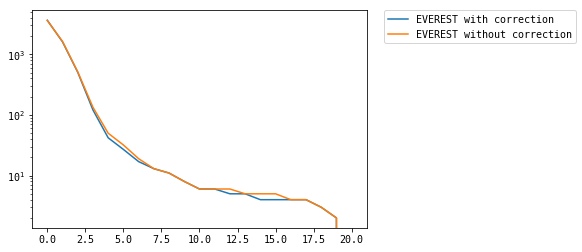

In [36]:
loc01 = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results/test_01'

sys01, d01 = systematics_wrap(loc01,oid_list,display=False)

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(d11,label='EVEREST with correction')
ax.plot(d01, label = 'EVEREST without correction')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_yscale('log')
f.show()    

In [37]:
sys11

[1332,
 1333,
 1334,
 1335,
 1336,
 1337,
 1338,
 1339,
 1518,
 1519,
 1520,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593]